# Baseline model

This notebook contains the model that we will use as a baseline to compare all others. The architecture we will deploy is a simple CNN. This model will be trained and tested over partitions of the the COCO 2014 training dataset. 

TO DO:
- fix plot finale e mettilo in plots.py e importa

## Libraries import

In [1]:
import torch
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
from tqdm import tqdm
import torch.optim as optim
# our modules
from utils.dataset import CocoDataset
from utils.plots import plot_l, plot_a, plot_b, plot_rgb, reconstruct_lab

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Data Import

In [3]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(), # tensorization brings image in range [0,1] and space CxHxW
])

In [4]:
path_sandro = "coco/images/train2014"
path_diego = "C:/Users/diego/coco/images/train2014/train2014"
dataset = CocoDataset(root=path_sandro, transform=transform)

Found 82783 images.


In [5]:
len(dataset)

82783

In [6]:
image, l_channel, a_channel, b_channel, ab_channels = dataset[0]

In [7]:
type(image), type(l_channel), type(a_channel), type(b_channel), type(ab_channels)

(torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor)

In [8]:
image.shape, l_channel.shape, a_channel.shape, b_channel.shape, ab_channels.shape

(torch.Size([3, 64, 64]),
 torch.Size([1, 64, 64]),
 torch.Size([64, 64]),
 torch.Size([64, 64]),
 torch.Size([2, 64, 64]))

Let's test the plotting functions

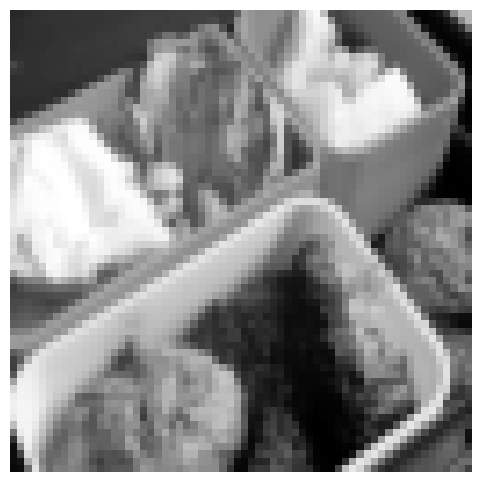

In [9]:
plot_l(l_channel)

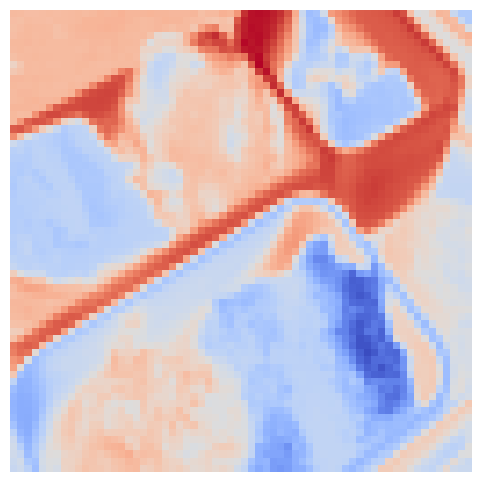

In [10]:
plot_a(a_channel)

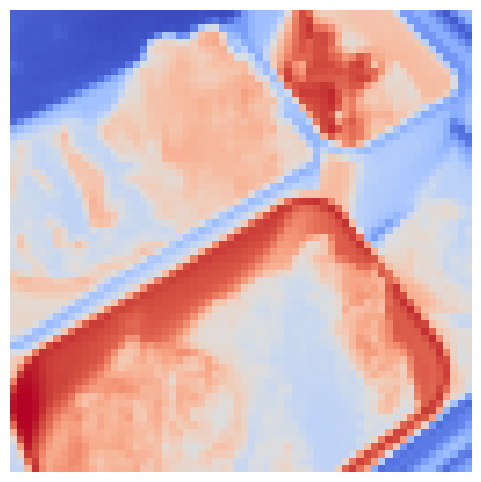

In [11]:
plot_b(b_channel)

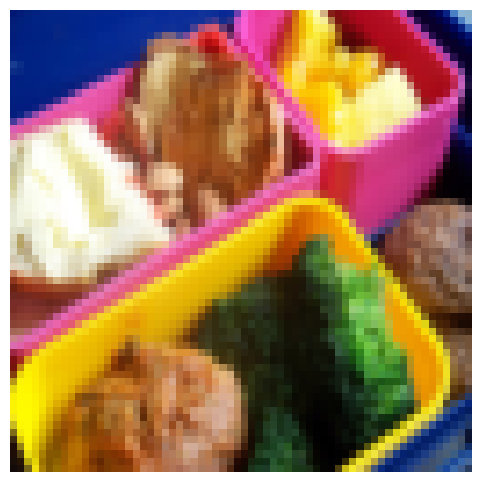

In [12]:
plot_rgb(image)

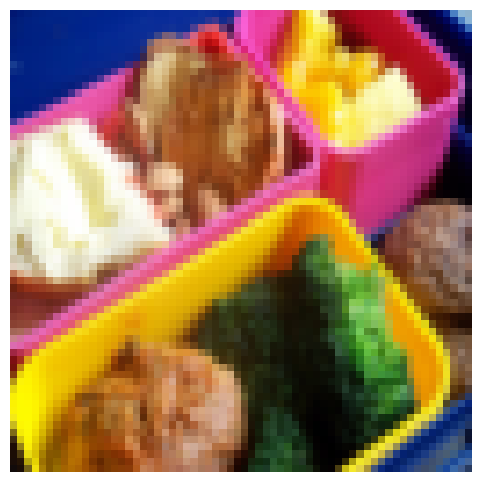

In [13]:
reconstruct_lab(l_channel, ab_channels)

## Data Preparation

We split our dataset in train and test data.

In [14]:
test_size = int(0.2 * len(dataset))
train_size = len(dataset) - test_size

In [15]:
torch.manual_seed(42)
train, test = random_split(dataset, [train_size, test_size], torch.Generator().manual_seed(42))

train_loader = DataLoader(train, batch_size=64, shuffle=True)
test_loader = DataLoader(test, batch_size=64, shuffle=True)

In [16]:
for x in train_loader:
    print(len(x)) # x is a list of len 5: image, l_channel, a_channel, b_channel, ab_channels
    print(f"Image shape {x[0].shape}\nL shape {x[1].shape}\nA shape {x[2].shape}\nB shape {x[3].shape}\nAB shape {x[4].shape}")
    break

5
Image shape torch.Size([64, 3, 64, 64])
L shape torch.Size([64, 1, 64, 64])
A shape torch.Size([64, 64, 64])
B shape torch.Size([64, 64, 64])
AB shape torch.Size([64, 2, 64, 64])


## CNN Model

For the moment, we will work with a small subset of the training data

In [17]:
torch.manual_seed(42)
train_size = 5000
small_train, _ = random_split(train, [train_size, len(train) - train_size], torch.Generator().manual_seed(42))
small_train_loader = DataLoader(small_train, batch_size=64, shuffle=True)
test_size = 1000
small_test, _ = random_split(test, [test_size, len(test) - test_size], torch.Generator().manual_seed(42))
small_test_loader = DataLoader(small_test, batch_size=64, shuffle=True)

In [19]:
len(small_train), len(small_test)

(5000, 1000)

In [20]:
class ColorizationCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 2, kernel_size=3, padding=1)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.layers(x)
        return self.sigmoid(x)

## Training

In [21]:
model = ColorizationCNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [22]:
NUM_EPOCHS = 10
train_losses = []
test_losses = []

for epoch in range(NUM_EPOCHS):
    running_loss = 0.0
    test_loss = 0.0

    # train loop
    model.train()
    progress_bar = tqdm(small_train_loader, desc=f'Epoch {epoch + 1}/{NUM_EPOCHS}', leave=True)
    for _, l_channels, _, _, ab_channels in progress_bar:
        l_channels = l_channels.to(device)
        ab_channels = ab_channels.to(device)
        
        optimizer.zero_grad()
        outputs = model(l_channels)
        loss = criterion(outputs, ab_channels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        progress_bar.set_postfix(loss=(running_loss / (progress_bar.n + 1)))
    
    train_losses.append(running_loss / len(small_train_loader))
    print(f"Epoch {epoch + 1}, Train Loss: {train_losses[-1]}")
    
    # test loop
    model.eval()
    with torch.no_grad():
        for _, l_channels, _, _, ab_channels in tqdm(small_test_loader, desc='Testing', leave=True):
            l_channels = l_channels.to(device)
            ab_channels = ab_channels.to(device)
            
            outputs = model(l_channels)
            loss = criterion(outputs, ab_channels)
            test_loss += loss.item()
        
    test_loss /= len(small_test_loader)
    test_losses.append(test_loss)
    print(f"Epoch {epoch + 1}, Validation Loss: {test_loss}")
    
print('Finished Training')

Epoch 1/10: 100%|██████████| 79/79 [00:48<00:00,  1.63it/s, loss=0.00606]


Epoch 1, Train Loss: 0.006055198583303939


Testing: 100%|██████████| 16/16 [00:08<00:00,  1.94it/s]


Epoch 1, Validation Loss: 0.003108007033006288


Epoch 2/10: 100%|██████████| 79/79 [00:44<00:00,  1.79it/s, loss=0.00307]


Epoch 2, Train Loss: 0.0030735152290214465


Testing: 100%|██████████| 16/16 [00:08<00:00,  1.99it/s]


Epoch 2, Validation Loss: 0.0031583289965055883


Epoch 3/10: 100%|██████████| 79/79 [00:38<00:00,  2.05it/s, loss=0.00307]


Epoch 3, Train Loss: 0.0030728451100095542


Testing: 100%|██████████| 16/16 [00:06<00:00,  2.42it/s]


Epoch 3, Validation Loss: 0.003125769639154896


Epoch 4/10: 100%|██████████| 79/79 [00:38<00:00,  2.03it/s, loss=0.00308]


Epoch 4, Train Loss: 0.0030796585569181772


Testing: 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 4, Validation Loss: 0.003104285235167481


Epoch 5/10: 100%|██████████| 79/79 [00:39<00:00,  1.99it/s, loss=0.00308]


Epoch 5, Train Loss: 0.003076907150046546


Testing: 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]


Epoch 5, Validation Loss: 0.0031202443060465157


Epoch 6/10: 100%|██████████| 79/79 [00:43<00:00,  1.82it/s, loss=0.00311]


Epoch 6, Train Loss: 0.0031073163440333137


Testing: 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]


Epoch 6, Validation Loss: 0.003149390366161242


Epoch 7/10: 100%|██████████| 79/79 [00:45<00:00,  1.73it/s, loss=0.00309]


Epoch 7, Train Loss: 0.0030946508315215005


Testing: 100%|██████████| 16/16 [00:06<00:00,  2.29it/s]


Epoch 7, Validation Loss: 0.0031358174310298637


Epoch 8/10: 100%|██████████| 79/79 [00:38<00:00,  2.03it/s, loss=0.00309]


Epoch 8, Train Loss: 0.003091435552327127


Testing: 100%|██████████| 16/16 [00:07<00:00,  2.21it/s]


Epoch 8, Validation Loss: 0.003079697926295921


Epoch 9/10: 100%|██████████| 79/79 [00:38<00:00,  2.04it/s, loss=0.00307]


Epoch 9, Train Loss: 0.0030732862798709282


Testing: 100%|██████████| 16/16 [00:06<00:00,  2.39it/s]


Epoch 9, Validation Loss: 0.003093517036177218


Epoch 10/10: 100%|██████████| 79/79 [00:39<00:00,  2.02it/s, loss=0.00306]


Epoch 10, Train Loss: 0.003062011856774363


Testing: 100%|██████████| 16/16 [00:06<00:00,  2.45it/s]

Epoch 10, Validation Loss: 0.00310301870922558
Finished Training


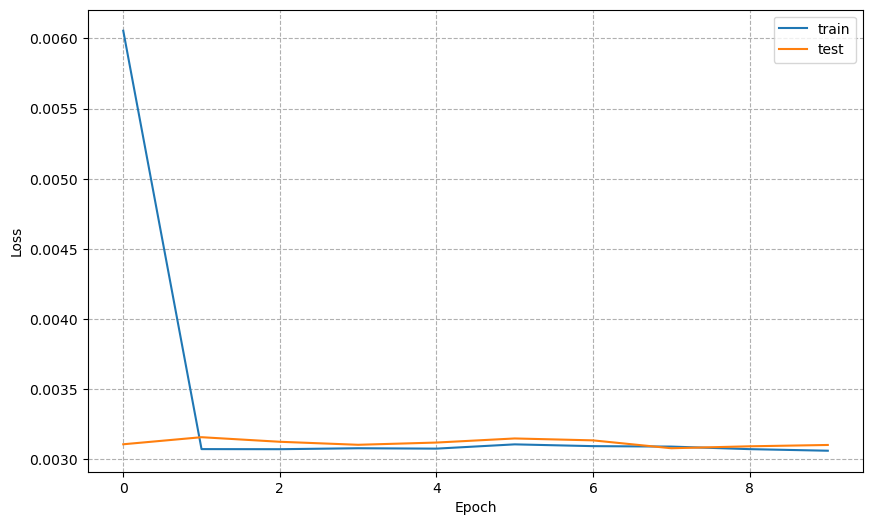

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(linestyle = "--")
plt.legend()
plt.show()

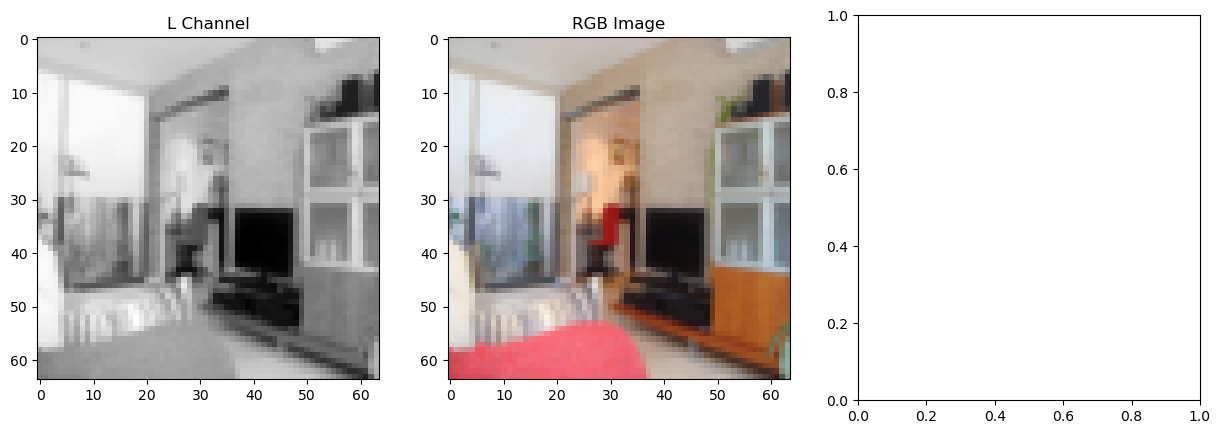

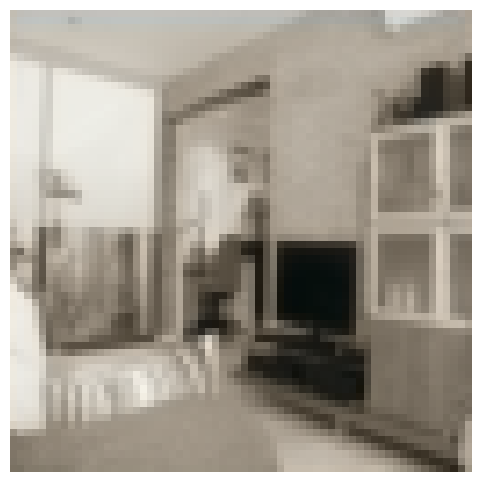

In [70]:
def plot_colorized_image(model, img, device="cuda"):
    # add docstring come nelle altre e metti in plots.py 
    l_channel = img[1].to(device)
    rgb = img[0].to(device)

    with torch.no_grad():
        ab_pred = model(l_channel)

    # Create subplots with 1 row and 3 columns
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    # Plot L channel
    axs[0].imshow(l_channel.detach().cpu().numpy().squeeze(), cmap='gray')
    axs[0].set_title('L Channel')

    # Plot RGB image
    axs[1].imshow(rgb.detach().cpu().numpy().transpose(1, 2, 0))
    axs[1].set_title('RGB Image')

    # Plot reconstructed LAB image
    reconstruct_lab(l_channel.detach().cpu(), ab_pred.detach().cpu())
    axs[2].set_title('Reconstructed LAB')

    plt.show()

plot_colorized_image(model, dataset[76543])


# Save and Load Model (non ho salvato)

In [49]:
# save weights
# run only if necessary... scriviamo una funzione anche per questa in futuro
from pathlib import Path
PATH = Path("models") 
PATH.mkdir(parents=True, # create parent directories if needed
           exist_ok=True # if models directory already exists, don't error
)
MODEL_NAME = "cnn_basic_1.pth"
MODEL_PATH = PATH / MODEL_NAME
torch.save(obj=model.state_dict(), f=MODEL_PATH)
print(f"Model saved to {MODEL_PATH} succesfully!")

Model saved to models\cnn_basic_1.pth succesfully!


In [51]:
# load model
# start from here if you don't want to do training again
loaded_model = ColorizationCNN() # create instance
loaded_model.load_state_dict(torch.load(f=MODEL_PATH)) # upload weights
print(f"{loaded_model._get_name()} model uploaded succesfully!")
loaded_model= loaded_model.to(device) # send it to gpu

ColorizationCNN model uploaded succesfully!
